# 📑 PROYECTO: A/B test and hypothesis analysis

## 🏢 Descripción del Proyecto

Este proyecto se desarrolla en el contexto de una gran tienda online que ofrece una amplia gama de productos a sus clientes. El equipo de marketing, en colaboración con el área de análisis, ha generado un conjunto de hipótesis enfocadas en mejorar los ingresos del negocio. Como analista de datos, tu rol es evaluar estas hipótesis, priorizarlas usando marcos de decisión cuantitativos, y analizar los resultados de un test A/B ya ejecutado, con el objetivo de tomar decisiones informadas y respaldadas por datos.

## 🎯 Objetivo

Evaluar y priorizar hipótesis que podrían aumentar los ingresos de la tienda online, utilizando métricas objetivas y modelos de priorización.

Analizar los resultados de un experimento A/B para determinar si hay diferencias estadísticamente significativas en el comportamiento de los usuarios entre los grupos de prueba, y tomar decisiones de negocio basadas en los hallazgos.

Este análisis permitirá a la empresa tomar decisiones estratégicas informadas sobre qué iniciativas implementar y qué estrategias de marketing o experiencia de usuario deben ser optimizadas.



## 🧾 Información de los Datasets

📄 **Ruta:** `hypotheses_us.csv`

| Columna      | Descripción                                                                 |
|--------------|------------------------------------------------------------------------------|
| `Hypotheses` | Breves descripciones de las hipótesis.                                      |
| `Reach`      | Alcance del usuario, en una escala del 1 al 10.                             |
| `Impact`     | Impacto en los usuarios, en una escala del 1 al 10.                         |
| `Confidence` | Confianza en la hipótesis, en una escala del 1 al 10.                       |
| `Effort`     | Recursos necesarios para probar una hipótesis (escala del 1 al 10).         |


📄 **Ruta:** `orders_us.csv`

| Columna         | Descripción                                                                 |
|------------------|-----------------------------------------------------------------------------|
| `transactionId`  | Identificador del pedido.                                                   |
| `visitorId`      | Identificador del usuario que realizó el pedido.                           |
| `date`           | Fecha del pedido.                                                           |
| `revenue`        | Ingresos del pedido.                                                        |
| `group`          | Grupo del test A/B al que pertenece el usuario.                             |

📄 **Ruta:** `visits_us.csv`

| Columna | Descripción                                                                 |
|---------|------------------------------------------------------------------------------|
| `date`  | Fecha de la visita.                                                         |
| `group` | Grupo del test A/B.                                                         |
| `visits`| Número de visitas en la fecha especificada para el grupo correspondiente.   |

## 🗂️ Carga y revisión inicial de datos

In [9]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [10]:
# Cargar el archivo CSV
df_hypotheses = pd.read_csv('hypotheses_us.csv', sep=';')

In [11]:
# Verificar las primeras filas de los datos
display(df_hypotheses)
print()
print(df_hypotheses.info())

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes
None


In [12]:
# Cargar el archivo CSV
df_orders_raw = pd.read_csv('orders_us.csv')
df_visits = pd.read_csv('visits_us.csv')

In [13]:
display(df_orders_raw.head(5))
print(df_orders_raw.info())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
None


In [14]:
display(df_visits.head(5))
print(df_visits.info())

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


## Priorizar hipótesis (Parte 1)

### Framework ICE para priorizar hipótesis

In [17]:
# ICE score = (Impact x Confidence) / Effort
df_hypotheses['ICE_score'] = (df_hypotheses['Impact'] * df_hypotheses['Confidence']) / df_hypotheses['Effort']
# Ordenar el DataFrame en orden descendente por la columna 'ICE_score'
df_hypotheses_ICE = df_hypotheses.copy()
df_hypotheses_ICE = df_hypotheses_ICE.sort_values(by='ICE_score', ascending=False)
display(df_hypotheses_ICE[['Hypothesis','ICE_score']])

,Hypothesis,ICE_score
8,Launch a promotion that gives users discounts ...,16.200000
0,Add two new channels for attracting traffic. T...,13.333333
7,Add a subscription form to all the main pages....,11.200000
6,Show banners with current offers and sales on ...,8.000000
2,Add product recommendation blocks to the store...,7.000000
1,Launch your own delivery service. This will sh...,2.000000
5,Add a customer review page. This will increase...,1.333333
3,Change the category structure. This will incre...,1.125000
4,Change the background color on the main page. ...,1.000000


In [18]:
# RICE score = (Reach x Impact x Confidence) / Effort
df_hypotheses['RICE_score'] = (df_hypotheses['Reach'] * df_hypotheses['Impact'] * df_hypotheses['Confidence']) / df_hypotheses['Effort']
# Ordenar el DataFrame en orden descendente por la columna 'ICE_score'
df_hypotheses_RICE = df_hypotheses.copy()
df_hypotheses_RICE = df_hypotheses_RICE.sort_values(by='RICE_score', ascending=False)
display(df_hypotheses_RICE[['Hypothesis','RICE_score']])

,Hypothesis,RICE_score
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


In [19]:
df_hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort,ICE_score,RICE_score
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2


In [20]:
# Comparar los cambios en la priorización
ice_hypotheses = df_hypotheses_ICE[['Hypothesis','ICE_score']]
ice_hypotheses = ice_hypotheses['Hypothesis'].values
rice_hypotheses = df_hypotheses_RICE[['Hypothesis','RICE_score']]
rice_hypotheses = rice_hypotheses['Hypothesis'].values

print("\nCambio en la priorización entre ICE y RICE:")
for ice, rice in zip(ice_hypotheses, rice_hypotheses):
    print(f"ICE: {ice} | RICE: {rice}")


Cambio en la priorización entre ICE y RICE:
ICE: Launch a promotion that gives users discounts on their birthdays | RICE: Add a subscription form to all the main pages. This will help you compile a mailing list
ICE: Add two new channels for attracting traffic. This will bring 30% more users | RICE: Add product recommendation blocks to the store's site. This will increase conversion and average purchase size
ICE: Add a subscription form to all the main pages. This will help you compile a mailing list | RICE: Add two new channels for attracting traffic. This will bring 30% more users
ICE: Show banners with current offers and sales on the main page. This will boost conversion | RICE: Show banners with current offers and sales on the main page. This will boost conversion
ICE: Add product recommendation blocks to the store's site. This will increase conversion and average purchase size | RICE: Launch a promotion that gives users discounts on their birthdays
ICE: Launch your own delivery se

**Conclusión<br>ICE prioriza hipótesis que requieren menos esfuerzo, y tiene en cuenta solo impacto, confianza y esfuerzo.<br>RICE le da mayor peso al alcance, lo que modificó la priorización. Esto se nota en cómo las hipótesis que afectan a más usuarios o que tienen un potencial mayor para impactar a la base de usuarios completa se priorizan más en RICE.**

La hipótesis "Launch a promotion that gives users discounts on their birthdays" tiene un ICE score de 16.2, que es el puntaje más alto, por lo que debería recibir alta prioridad.Sin embargo, con la metodologia RICE esta hipótesis pasa al 5to puesto de prioridad debido a que no tiene gran alcance. <br> La hipótesis "Add a subscription form to all the main pages. This will help you compile a mailing list" tiene un RICE score de 112, que es el puntaje más alto, por lo que debería recibir alta prioridad. Esta hipostesis también aparece en el tercer puesto de prioridad del ICE.

### 💡 Recomendaciones

Prioriza las hipótesis con alto RICE, ya que este framework toma en cuenta el alcance del cambio, lo cual es crucial en estrategias escalables. Implementar primero las que requieren menos recursos y tienen alto alcance e impacto te permitirá obtener resultados rápidos y valiosos, optimizando el uso del tiempo y presupuesto del equipo.

🔝 Hipótesis más recomendadas (según RICE):<br>
1. Add a subscription form to all the main pages.<br>
RICE score: 112.0 → ⭐ Mayor puntuación<br>
Alta combinación de reach (10), impact (7), y confianza (8), con un esfuerzo moderado (5).<br>
Muy efectiva a escala, con bajo costo relativo y alta probabilidad de éxito.<br>

2. Add product recommendation blocks to the store.<br>
RICE score: 56.0<br>
Tiene buen alcance (8) y confianza (7) con bajo esfuerzo (3).<br>
Ideal para mejorar conversión sin gran inversión.<br>

3. Add two new channels for attracting traffic.<br>
RICE score: 40.0<br>
Aunque el alcance es menor (3), el impacto (10) y confianza (8) son altos.<br>
Interesante si se busca atraer nuevos usuarios con buen retorno.

## Análisis del test A/B (Parte 2)

### 🧑‍💻 Preprocesamiento de Datos

Convertir la columna date de los data frames df_orders y df_visits a tipo 'datetime64[ns]'

In [27]:
# Verificar el tipo de dato de la columna 'date' del dataframe df_orders
print(df_orders_raw['date'].dtype)

object


In [28]:
# Ahora usa map() para convertir cada valor de la columna 'date' a datetime
df_orders_raw['date'] = df_orders_raw['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

# Verifica que la conversión se haya realizado correctamente
print(df_orders_raw['date'].dtype)  # Ahora la columna date debe ser del tipo 'datetime64[ns]'

datetime64[ns]


In [29]:
# Verificar el tipo de dato de la columna 'date' del dataframe df_visits
print(df_visits['date'].dtype)

object


In [30]:
# Ahora usa map() para convertir cada valor de la columna 'date' de df_visits a datetime
df_visits['date'] = df_visits['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

# Verifica que la conversión se haya realizado correctamente
print(df_visits['date'].dtype)  

datetime64[ns]


Algunos de los visitantes podrían haber entrado tanto en el grupo A como en el grupo B.

In [32]:
# Realiza un groupby() para contar las ocurrencias
df_1 = df_orders_raw.groupby(['visitorId', 'group']).size().reset_index(name='count')
# Ahora filtra las filas donde 'visitorId' tiene duplicados
duplicated_visitorIds = df_1[df_1.duplicated(subset=['visitorId'], keep=False)]
# Mostrar el DataFrame con los duplicados
print(duplicated_visitorIds.head(10))
print('cantidad de usuarios que entraron en grupo A y B:', duplicated_visitorIds['visitorId'].nunique())

    visitorId group  count
2     8300375     A      1
3     8300375     B      1
45  199603092     A      4
46  199603092     B      1
53  232979603     A      1
54  232979603     B      1
58  237748145     A      4
59  237748145     B      1
70  276558944     A      1
71  276558944     B      1
cantidad de usuarios que entraron en grupo A y B: 58


Son 58 usuarios que entraron en grupos A y B .Por lo tanto, eliminaré duplicados en el grupo con menos transacciones: Si un visitorId tiene transacciones tanto en el grupo A como en el grupo B, se eliminarán las filas del grupo con menos transacciones (es decir, se quedará solo en el grupo en el que tiene más transacciones).

In [34]:
# Contar el número de transacciones por grupo para cada visitorId
transaction_counts = df_orders_raw.groupby(['visitorId', 'group']).size().unstack(fill_value=0)

# Encontrar el grupo con más transacciones para cada visitorId
transaction_counts['max_group'] = transaction_counts.idxmax(axis=1)

# Ahora, asignamos el visitorId al grupo con más transacciones
df_orders_raw['final_group'] = df_orders_raw['visitorId'].map(transaction_counts['max_group'])

# Filtrar los datos para que cada visitorId esté solo en el grupo con más transacciones
df_orders = df_orders_raw[df_orders_raw['group'] == df_orders_raw['final_group']]

# Seleccionar solo las columnas con las que se trabajará
df_orders = df_orders[['transactionId', 'visitorId', 'date', 'revenue', 'group']]

# Ver el DataFrame limpio
print(df_orders.head(5)) 
print()
print(df_orders.info()) 
# # Comprobar
# print(df_orders_cleaned[df_orders_cleaned['visitorId']==237748145])

   transactionId   visitorId       date  revenue group
0     3667963787  3312258926 2019-08-15     30.4     B
1     2804400009  3642806036 2019-08-15     15.2     B
2     2961555356  4069496402 2019-08-15     10.2     A
3     3797467345  1196621759 2019-08-15    155.1     B
4     2282983706  2322279887 2019-08-15     40.5     B

<class 'pandas.core.frame.DataFrame'>
Index: 1126 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1126 non-null   int64         
 1   visitorId      1126 non-null   int64         
 2   date           1126 non-null   datetime64[ns]
 3   revenue        1126 non-null   float64       
 4   group          1126 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 52.8+ KB
None


### Análisis del test A/B 

#### Representación gráfica del ingreso acumulado por grupo. 

In [37]:
# Eliminar duplicados para las columnas 'date' y 'group'
datesGroups = df_orders[['date', 'group']].drop_duplicates()
# Realizar la agregación
ordersAggregated = datesGroups.apply(
    lambda x: df_orders[
        np.logical_and(
            df_orders['date'] <= x['date'], df_orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',  # El valor máximo de la fecha
            'group': 'max',  # El valor máximo del grupo (que debería ser siempre el mismo para un grupo)
            'transactionId': pd.Series.nunique,  # Número de transacciones únicas
            'visitorId': pd.Series.nunique,  # Número de visitantes únicos (comprobar)
            'revenue': 'sum',  # Suma de los ingresos
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# Verificar el resultado
print(ordersAggregated.tail(5))

          date group  transactionId  visitorId  revenue
533 2019-08-29     B            550        503  79771.3
730 2019-08-30     A            525        480  60962.9
690 2019-08-30     B            572        524  83093.9
958 2019-08-31     A            537        490  61954.3
930 2019-08-31     B            589        541  84881.6


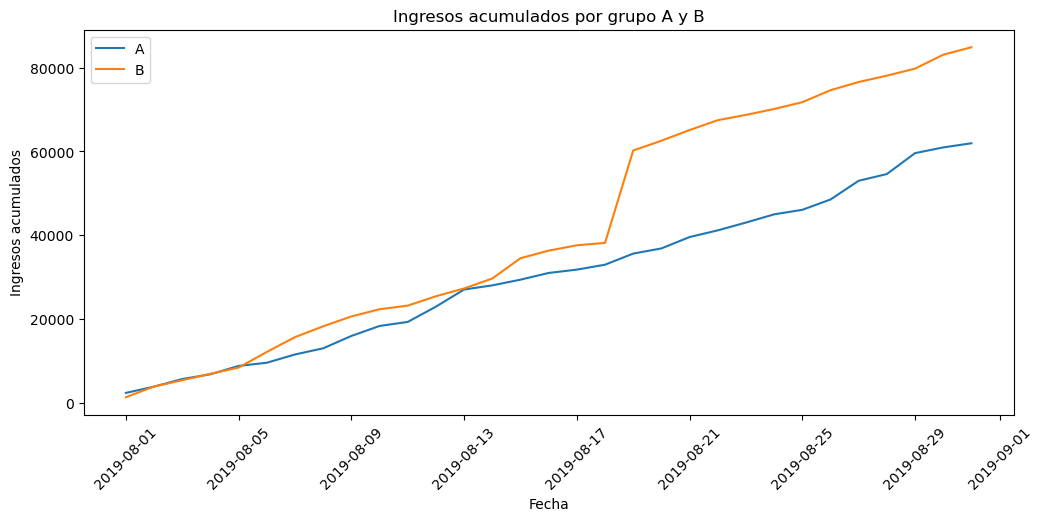

In [38]:
plt.figure(figsize=(12, 5))  # (ancho, alto)

# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo A
cumulativeRevenueA = ordersAggregated[ordersAggregated['group']=='A'][['date','revenue']]

# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo B
cumulativeRevenueB = ordersAggregated[ordersAggregated['group']=='B'][['date','revenue']]

# Trazar el gráfico de ingresos del grupo A
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Trazar el gráfico de ingresos del grupo B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()

# Añadir etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Ingresos acumulados')
plt.title('Ingresos acumulados por grupo A y B')

# Rotar las etiquetas del eje X a 45 grados
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

**Conclusiones**<br>Este análisis muestra que el grupo B ha logrado un crecimiento significativamente más rápido a partir del día 5, con un gran impulso en el día 19, mientras que el grupo A parece haber quedado rezagado.<br>El grupo A sigue una curva lineal en su gráfico. Es decir, el grupo A está generando casi la misma cantidad de ingresos adicionales cada día.

#### Representa gráficamente el tamaño de pedido promedio acumulado por grupo. 

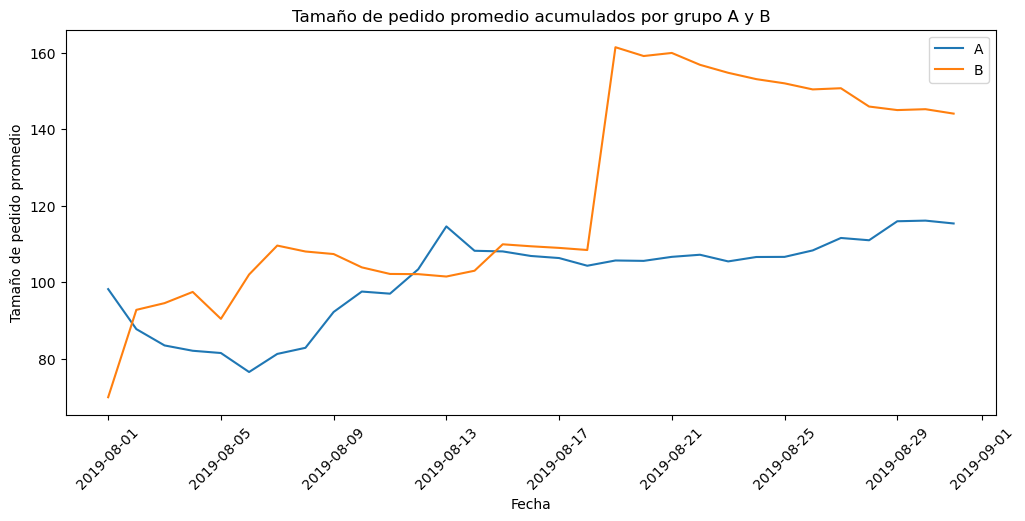

In [41]:
plt.figure(figsize=(12, 5))  # (ancho, alto)
cumulativeRevenueA_1 = ordersAggregated[ordersAggregated['group']=='A'][['date','revenue','transactionId']
]
cumulativeRevenueB_1 = ordersAggregated[ordersAggregated['group']=='B'][['date','revenue','transactionId']
]

plt.plot(cumulativeRevenueA_1['date'], cumulativeRevenueA_1['revenue']/cumulativeRevenueA_1['transactionId'], label='A')
plt.plot(cumulativeRevenueB_1['date'], cumulativeRevenueB_1['revenue']/cumulativeRevenueB_1['transactionId'], label='B')
plt.legend()

# Añadir etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Tamaño de pedido promedio')
plt.title('Tamaño de pedido promedio acumulados por grupo A y B')

# Rotar las etiquetas del eje X a 45 grados
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

**Conclusiones**<br> Del grupo A: A medida que avanza el mes, se observa que el tamaño de pedido promedio tiende a aumentar gradualmente.<br>En las primeras semanas del mes, el tamaño de los pedidos se mantiene relativamente estable y ligeramente decreciente (el valor promedio comienza en torno a 98.20 y baja a 76.51 en los primeros días). Sin embargo, esto parece estabilizarse y luego subir progresivamente hacia el final.

Del grupo B: el tamaño de pedido promedio en el grupo B tiende a aumentar a medida que avanza el mes. Sin embargo, la diferencia clave es que en el grupo B el aumento es más consistente y pronunciado. A partir del día 19 de agosto, se ve un aumento más agresivo en el tamaño de los pedidos, lo que podría indicar una estrategia o cambio significativo que favoreció un aumento en el valor promedio de los pedidos.

#### Representa gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A.

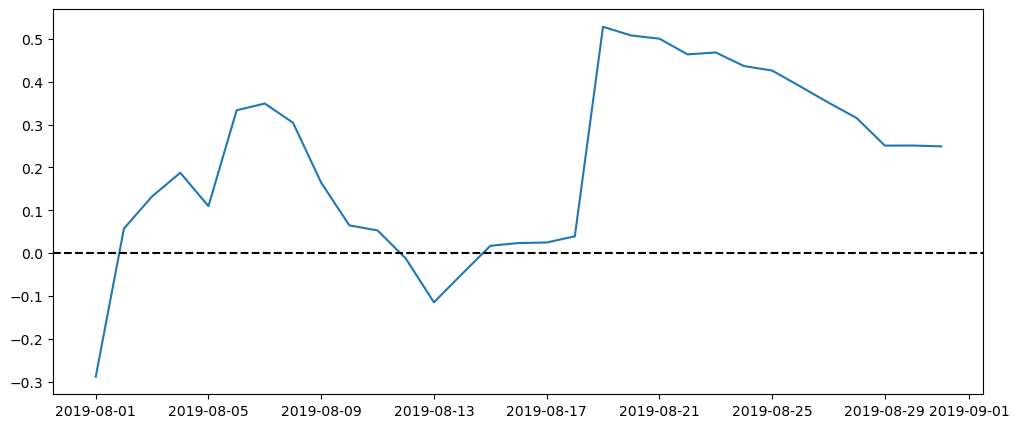

In [44]:
# reunir los datos en un DataFrame
mergedCumulativeRevenue = cumulativeRevenueA_1.merge(cumulativeRevenueB_1, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12, 5))  # (ancho, alto)
# trazar un gráfico de diferencia relativa para los tamaños de pedido promedio
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['transactionIdB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['transactionIdA'])-1)

# agregar el eje X
plt.axhline(y=0, color='black', linestyle='--')

**Conclusión**<br>Si el resultado es 0, significa que el tamaño promedio de pedido de B es igual al de A.<br>Si el resultado es positivo, significa que el tamaño promedio de pedido de B es mayor que el de A en ese porcentaje.<br>Si el resultado es negativo, significa que el tamaño promedio de pedido de B es menor que el de A en ese porcentaje.

Por lo que se observa en el gráfico, el tamaño promedio de pedido de B es mayor que el de A.

#### Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia. 

<!-- #### Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia. Saca conclusiones y haz conjeturas. -->

In [48]:
visitorsAggregated = datesGroups.apply(
    lambda x: df_visits[
        np.logical_and(
            df_visits['date'] <= x['date'], df_visits['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visits': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])
# display(visitorsAggregated)

In [49]:
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'transactions',
    'users',
    'revenue',
    'visitors',
]
display(cumulativeData.head(5))

,date,group,transactions,users,revenue,visitors
0,2019-08-01,A,24,20,2356.8,719
1,2019-08-01,B,19,18,1328.4,713
2,2019-08-02,A,44,38,3860.3,1338
3,2019-08-02,B,42,40,3896.5,1294
4,2019-08-03,A,68,62,5675.5,1845


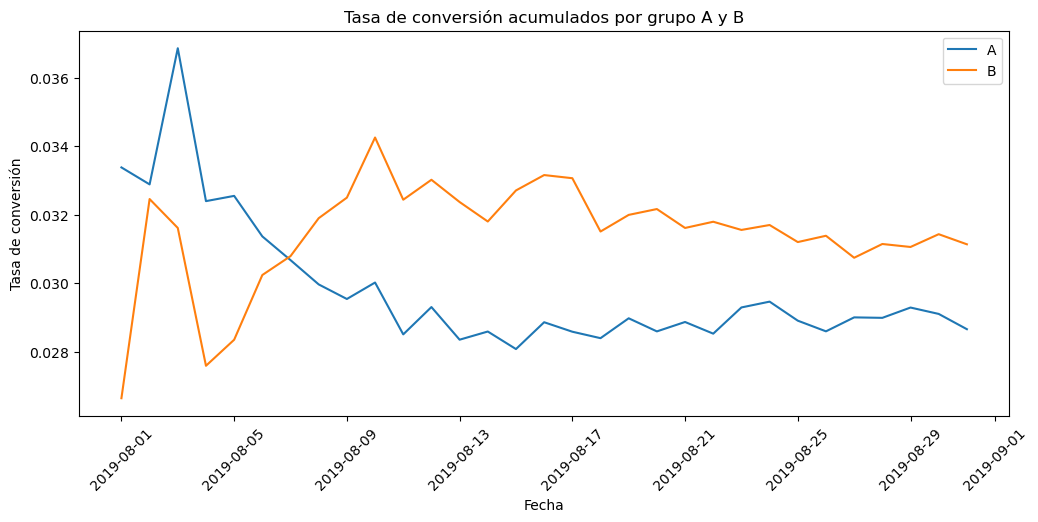

In [50]:
# calcular la conversión acumulada
cumulativeData['conversion'] = cumulativeData['transactions']/cumulativeData['visitors']

# seleccionar datos en el grupo A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# seleccionar datos en el grupo B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(12, 5))  # (ancho, alto)
# trazar los gráficos
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# Añadir etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Tasa de conversión')
plt.title('Tasa de conversión acumulados por grupo A y B')

# Rotar las etiquetas del eje X a 45 grados
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

**Conclusión**<br>**Grupo A**: la disminución de la tasa de conversión sugiere que la eficiencia de la conversión podría estar decayendo. El equipo podría necesitar ajustes en las estrategias de marketing.Al principio del mes, el Grupo A puede haber atraído tráfico más cualificado (visitantes que tenían más probabilidades de convertirse en clientes), lo que resultó en una tasa de conversión más alta.A medida que el mes avanzó, el número de visitantes aumentó, pero es posible que estos visitantes fueran menos cualificados o estuvieran menos interesados en realizar una conversión.<br>**Grupo B** ha mostrado una mayor estabilidad y ligera mejora en su tasa de conversión durante el mes de agosto, lo que podría indicar que sus estrategias de marketing, ventas o retención están siendo más efectivas.

#### Traza un gráfico de dispersión del número de pedidos por usuario.

In [53]:
display(df_orders.head(4))

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B


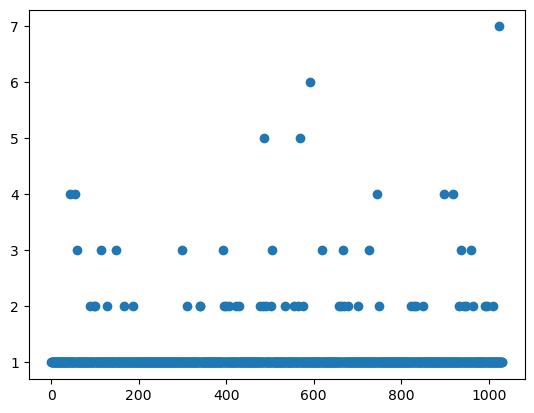

In [54]:
ordersByUsers = df_orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})

# Cambiar el nombre de las columnas para que sea 'userId' y 'orders'
ordersByUsers.columns = ['userId', 'orders']

# Ordenar los datos por el número de pedidos en orden descendente
ordersByUsers_sorted = ordersByUsers.sort_values(by='orders', ascending=False)

# el rango de números desde 0 hasta el número de observaciones en ordersByUsers
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])

**Conclusiones**<br> En el gráfico se observa que la mayoría de usuarios solo hace una transacción y algunos cuantos hacen hasta dos transacciones. Hay muy pocos usuarios que realizan mas de 3 transacciones. Se observa algunos valores atípicos.

#### Calcula los percentiles 95 y 99 del número de pedidos por usuario. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [57]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[1. 2. 3.]


**Conclusiones**<br>La gran mayoría de los usuarios han realizado pocos pedidos. El 90% de los usuarios ha realizado 1 pedido, el 95% ha hecho 2 pedidos o menos, y el 99% ha hecho 4 pedidos o menos. Esto indica que la mayoría de los usuarios no está comprando con frecuencia.

Entonces, cualquier usuario con más de 4 pedidos podría ser considerado como un outlier o anomalía en términos de comportamiento de compra, porque está significativamente fuera de la distribución de los demás usuarios. 

#### Traza un gráfico de dispersión de los precios de los pedidos. Haz conclusiones y conjeturas.

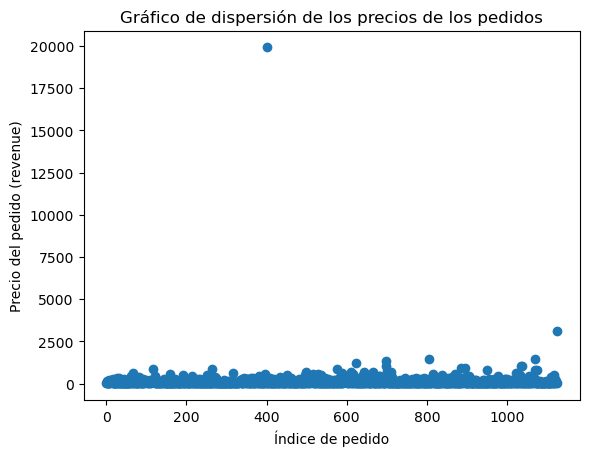

In [60]:
# Crear el rango de valores para el eje X (de 0 hasta el número de filas en df_orders)
x_values = pd.Series(range(0, len(df_orders)))

# Trazar el gráfico de dispersión de los precios de los pedidos (columna 'revenue')
plt.scatter(x_values, df_orders['revenue'])

# Títulos y etiquetas
plt.title("Gráfico de dispersión de los precios de los pedidos")
plt.xlabel("Índice de pedido")
plt.ylabel("Precio del pedido (revenue)")

# Mostrar el gráfico
plt.show()


#### Calcula los percentiles 95 y 99 de los precios de los pedidos. Define el punto en el cual un punto de datos se convierte en una anomalía.

In [62]:
# Calcular los percentiles 95 y 99 de los precios de los pedidos
percentile_95 = np.percentile(df_orders['revenue'], 95)
percentile_99 = np.percentile(df_orders['revenue'], 99)

# Imprimir los resultados
print(f"Percentil 95 de los precios de los pedidos: {percentile_95}")
print(f"Percentil 99 de los precios de los pedidos: {percentile_99}")

Percentil 95 de los precios de los pedidos: 425.75
Percentil 99 de los precios de los pedidos: 830.3


**Conclusiones**<br>El 95% de los pedidos están por debajo de 425.75.<br>El 99% de los pedidos están por debajo de 830.3.
Esto sugiere que hay pedidos con precios altos (probablemente unos pocos pedidos con un precio mucho mayor que la mayoría) que están empujando el percentil 99 a un valor relativamente alto.

#### Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto. 

In [65]:
ordersByUsersA = df_orders[df_orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']
# print(ordersByUsersA)
ordersByUsersB = df_orders[df_orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']
# print(ordersByUsersB)

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(df_visits[df_visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(df_visits[df_visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

# Realizar el test de Mann-Whitney
print('{0:.5f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))
# Calcular la diferencia relativa en las medias
print('{0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

0.14572
0.086


**Conclusiones**<br>**Prueba de Mann-Whitney (p = 0.14572):** Como el valor p es mayor que 0.05, no podemos rechazar la hipótesis nula, por lo tanto, no hay evidencia suficiente para afirmar que las distribuciones de conversión en los grupos A y B son diferentes. Los resultados entre los dos grupos podrían ser similares desde el punto de vista estadístico.

**Diferencia relativa**<br>Aunque la diferencia relativa de medias muestra que el grupo B tiene un promedio de conversión ligeramente mayor que el grupo A (8.6%), la prueba de Mann-Whitney indica que no hay evidencia estadística suficiente para afirmar que las conversiones entre los dos grupos son diferentes.

#### Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto. 

In [68]:
print('{0:.3f}'.format(stats.mannwhitneyu(df_orders[df_orders['group']=='A']['revenue'], df_orders[df_orders['group']=='B']['revenue'])[1])) 
# 
print('{0:.3f}'.format(df_orders[df_orders['group']=='B']['revenue'].mean()/df_orders[df_orders['group']=='A']['revenue'].mean()-1))                    

0.788
0.249


**Conclusionees**<br>**P-valor de la prueba de Mann-Whitney (0.788):** El valor 0.788 es alto (mayor que 0.05). Esto indica que no hay evidencia suficiente para rechazar la hipótesis nula, por lo tanto, no se puede concluir que las distribuciones de ingresos entre los dos grupos (A y B) sean significativamente diferentes.Es decir, las distribuciones de ingresos en ambos grupos son similares desde el punto de vista estadístico.<br>**Diferencia relativa en las medias (0.249):** Los ingresos medios del grupo B son aproximadamente un 24.9% más altos que los ingresos medios del grupo A.Es decir, si consideramos las medias de ingresos, el grupo B está generando un 24.9% más de ingresos en comparación con el grupo A.Sin embargo, debido a que el p-valor es alto (0.788), esta diferencia de 24.9% no se considera estadísticamente significativa.

#### Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados. 

Eliminar anomalías de los datos

In [72]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = df_orders[df_orders['revenue'] > percentile_99]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
# print(abnormalUsers)
num_elements = abnormalUsers.count()
print(f"El número de elementos no nulos en abnormalUsers es: {num_elements}")

El número de elementos no nulos en abnormalUsers es: 31


In [73]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                df_visits[df_visits['group'] == 'A']['visits'].sum()
                - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                df_visits[df_visits['group'] == 'B']['visits'].sum()
                - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print(
    "{0:.5f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])
)
print("{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))


0.10108
0.114


**Conclusión**<br>**P-valor de la prueba de Mann-Whitney (0.10108):** El p-valor de 0.10108 es mayor que 0.05, lo que sugiere que no hay evidencia suficiente para rechazar la hipótesis nula.Por lo tanto, se considera que las distribuciones de la conversión en los grupos A y B son iguales.<br>**Diferencia relativa en las medias (0.114):** La diferencia relativa de 0.114 significa que el grupo B tiene una tasa de conversión aproximadamente un 11.4% mayor que el grupo A.
Aunque este es un valor positivo, el p-valor alto (0.10108) nos indica que esta diferencia no es estadísticamente significativa.
Es decir, aunque en términos absolutos el grupo B parece tener una conversión ligeramente superior, la diferencia no es suficientemente robusta desde un punto de vista estadístico para afirmar que esta diferencia es consistente y no se debe a la variabilidad aleatoria.

#### Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados.

In [76]:
filtered_revenue_A = df_orders[
    np.logical_and(
        df_orders['group'] == 'A',  # Condición 1: grupo A
        np.logical_not(df_orders['visitorId'].isin(abnormalUsers)),  # Condición 2: visitorId no en abnormalUsers
    )
]['revenue']
filtered_revenue_B = df_orders[
    np.logical_and(
        df_orders['group'] == 'B',  # Condición 1: grupo A
        np.logical_not(df_orders['visitorId'].isin(abnormalUsers)),  # Condición 2: visitorId no en abnormalUsers
    )
]['revenue']
print(
    "{0:.3f}".format(
        stats.mannwhitneyu(
            filtered_revenue_A,
            filtered_revenue_B,
        )[1]
    )
)
print(
    "{0:.3f}".format(
        filtered_revenue_B.mean()
        / filtered_revenue_A.mean()
        - 1
    )
)


0.876
-0.025


**Conclusión**<br>**P-valor de la prueba de Mann-Whitney (0.876):** El p-valor de la prueba de Mann-Whitney es 0.876, que es mucho mayor que 0.05. Esto indica que no hay evidencia suficiente para rechazar la hipótesis nula.Por lo tanto, no podemos afirmar que haya una diferencia estadísticamente significativa en el tamaño de los pedidos entre los dos grupos, después de eliminar los usuarios anómalos.<br>**Diferencia relativa en las medias (-0.025):** La diferencia relativa en las medias es -0.025, lo que significa que el tamaño promedio del pedido en el grupo B es un 2.5% menor que en el grupo A. Aunque la diferencia es negativa, el p-valor alto (0.876) sugiere que esta diferencia no es significativa desde un punto de vista estadístico.

###💡 Recomendaciones

* Parar la prueba y concluir que no hay diferencia entre los grupos.
  
Razonamiento:

A pesar de que hay algunas diferencias numéricas (por ejemplo, un 11.4% más de conversión para el grupo B), estas no son estadísticamente significativas (p-valor > 0.05). Además, no se encontró ninguna diferencia significativa en el tamaño promedio de los pedidos.
Dado que no hay evidencia suficiente para afirmar que uno de los grupos es claramente superior al otro en términos de conversión o tamaño de pedido, concluir que no hay diferencia significativa parece ser lo más apropiado.

# Comentario general 

<div class="alert alert-block alert-success">  
<a class="tocSkip"></a>  
    

- **Limpieza y filtrado de datos:** Eliminación de anomalías, garantizando un análisis más preciso.  
- **Uso adecuado de pruebas estadísticas:** Implementación de pruebas de Mann-Whitney de manera correcta para evaluar la significancia de las diferencias entre grupos.  
- **Visualización y análisis:** Representación de los datos de manera efectiva mediante gráficos de dispersión y series de tiempo, permitiendo detectar patrones y tendencias en la conversión y el tamaño de los pedidos.  
- **Interpretación clara de resultados:** Las conclusiones están bien estructuradas y justificadas con base en la evidencia estadística.  
 
</div>